# Photometric Stereo Demonstration

This notebook demonstrates the complete flow of the photometric stereo experiment:
1. Generate synthetic dataset with ground truth
2. Run uncalibrated photometric stereo
3. Run calibrated photometric stereo
4. Visualize and compare results

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add src to path
sys.path.insert(0, str(Path.cwd() / 'src'))

from dataset import generate_dataset
from uncalibrated_ff import uncalibrated_photometric_stereo
from calibrated_ff import calibrated_photometric_stereo
from util import load_dataset

## 1. Generate Synthetic Dataset

Generate a dataset with multiple lighting directions. This will also automatically generate ground truth data.

In [6]:
# Configuration
MODEL_NAME = "bunny"  # Change to "bunny" or path to custom mesh
NUM_LIGHTS = 30
IMAGE_RES = 512
SAMPLES = 64

# Paths
PROJECT_DIR = Path.cwd()
DATASET_DIR = PROJECT_DIR / "dataset" / MODEL_NAME
RESULTS_DIR = PROJECT_DIR / "results" / MODEL_NAME

print(f"Dataset will be saved to: {DATASET_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

Dataset will be saved to: /home/stevenlee17/cmu/10701/10701_light_estimation/dataset/bunny
Results will be saved to: /home/stevenlee17/cmu/10701/10701_light_estimation/results/bunny


In [4]:
# Generate dataset (uncomment to run)
# This step takes a few minutes

# generate_dataset(
#     output_dir=str(PROJECT_DIR / "dataset"),
#     num_lights=NUM_LIGHTS,
#     image_res=IMAGE_RES,
#     samples=SAMPLES,
#     mesh=None  # Set to path for custom mesh
# )

print("Dataset generation complete!")
print(f"Generated {NUM_LIGHTS} images with ground truth")

Dataset generation complete!
Generated 30 images with ground truth


## 2. Load Dataset

Load the generated dataset with all channels (RGB, depth, normals, albedo).

In [7]:
# Load dataset
dataset = load_dataset(str(DATASET_DIR))

print(f"Dataset shape: {dataset.shape}")
print(f"Number of images: {len(dataset)}")
print(f"Image resolution: {dataset.shape[1]}x{dataset.shape[2]}")
print(f"Channels: {dataset.shape[3]} (RGB:3 + Depth:1 + Normals:3 + Albedo:3)")

Dataset shape: (30, 512, 512, 10)
Number of images: 30
Image resolution: 512x512
Channels: 10 (RGB:3 + Depth:1 + Normals:3 + Albedo:3)


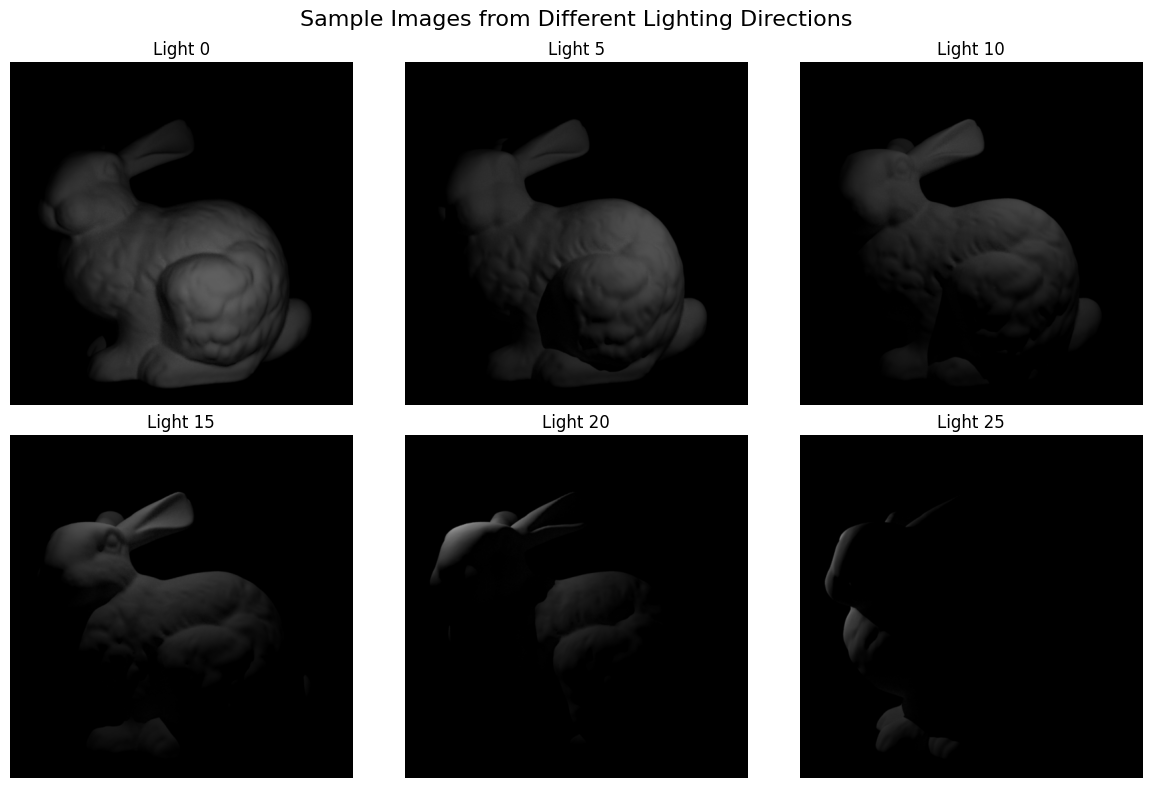

In [8]:
# Visualize sample images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Images from Different Lighting Directions', fontsize=16)

rgb_images = dataset.rgb()
sample_indices = [0, 5, 10, 15, 20, 25]

for idx, ax in zip(sample_indices, axes.flat):
    img = np.clip(rgb_images[idx], 0, 1)
    ax.imshow(img)
    ax.set_title(f'Light {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Run Uncalibrated Photometric Stereo

Estimate surface normals, albedo, and light directions without knowing the light directions.

In [9]:
print("Running uncalibrated photometric stereo...")

rgb_images = dataset.rgb()
num_lights = len(dataset)

normals_unc, albedos_unc, light_dirs_est, valid_mask = uncalibrated_photometric_stereo(
    rgb_images, 
    num_lights=num_lights
)

print("Uncalibrated photometric stereo complete!")
print(f"Normals shape: {normals_unc.shape}")
print(f"Albedos shape: {albedos_unc.shape}")
print(f"Estimated light directions shape: {light_dirs_est.shape}")

Running uncalibrated photometric stereo...
Uncalibrated photometric stereo complete!
Normals shape: (512, 512, 3)
Albedos shape: (512, 512)
Estimated light directions shape: (30, 3)


## 4. Run Calibrated Photometric Stereo

Estimate surface normals and albedo using known light directions.

In [10]:
print("Running calibrated photometric stereo...")

light_dirs_gt = dataset.light_directions()

normals_cal, albedos_cal, _ = calibrated_photometric_stereo(
    rgb_images, 
    light_dirs_gt
)

print("Calibrated photometric stereo complete!")
print(f"Normals shape: {normals_cal.shape}")
print(f"Albedos shape: {albedos_cal.shape}")

Running calibrated photometric stereo...
Calibrated photometric stereo complete!
Normals shape: (512, 512, 3)
Albedos shape: (512, 512)


## 5. Load Ground Truth

Load ground truth data for comparison.

In [11]:
# Extract ground truth from dataset
gt_normals = dataset.normals()[0]
gt_albedos_rgb = dataset.albedos()[0]

# Convert to grayscale albedo
gt_albedos = (
    0.2126 * gt_albedos_rgb[:, :, 0]
    + 0.7152 * gt_albedos_rgb[:, :, 1]
    + 0.0722 * gt_albedos_rgb[:, :, 2]
)

print("Ground truth loaded!")
print(f"GT Normals shape: {gt_normals.shape}")
print(f"GT Albedos shape: {gt_albedos.shape}")

Ground truth loaded!
GT Normals shape: (512, 512, 3)
GT Albedos shape: (512, 512)


## 6. Visualize Results - Normals

Compare estimated normals with ground truth.

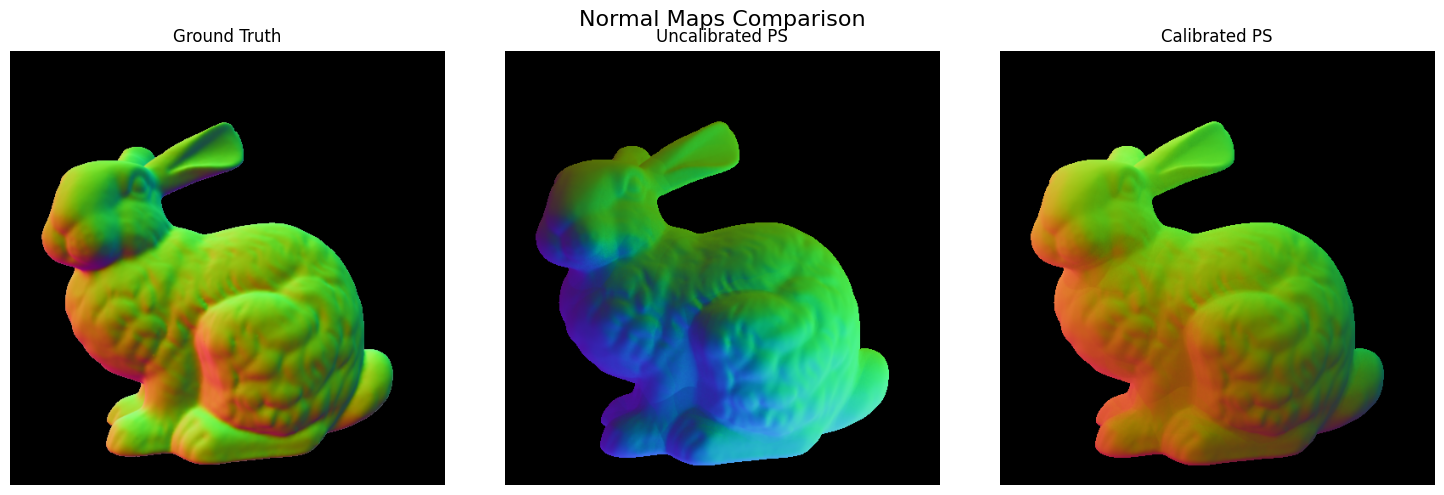

In [17]:
def visualize_normals(normals, mask=None):
    """Convert normals to RGB for visualization."""
    if mask is None:
        norms = np.linalg.norm(normals, axis=2)
        mask = (norms >= 0.5).astype(bool)

    vis_normals = (normals + 1.0) / 2.0
    vis_normals = np.clip(vis_normals, 0, 1)
    vis_normals[mask == 0] = 0
    return vis_normals

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Normal Maps Comparison', fontsize=16)

# Ground truth
axes[0].imshow(visualize_normals(gt_normals))
axes[0].set_title('Ground Truth')
axes[0].axis('off')

# Uncalibrated
axes[1].imshow(visualize_normals(normals_unc, valid_mask))
axes[1].set_title('Uncalibrated PS')
axes[1].axis('off')

# Calibrated
axes[2].imshow(visualize_normals(normals_cal, valid_mask))
axes[2].set_title('Calibrated PS')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 7. Visualize Results - Albedo

Compare estimated albedo with ground truth.

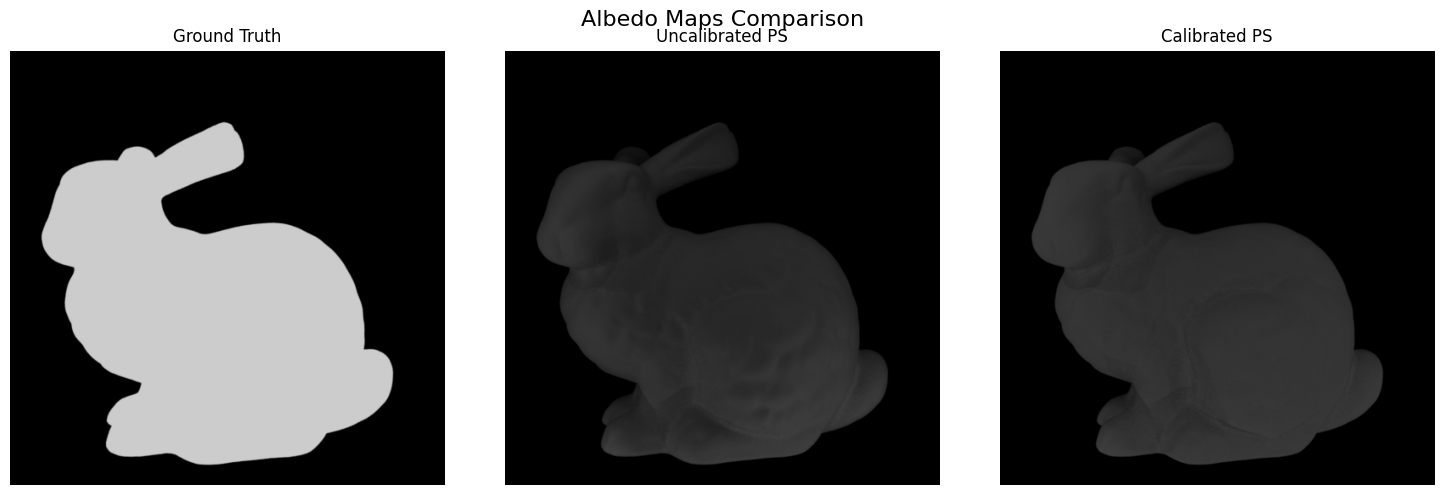

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Albedo Maps Comparison', fontsize=16)

# Ground truth
axes[0].imshow(gt_albedos, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Ground Truth')
axes[0].axis('off')

# Uncalibrated
axes[1].imshow(albedos_unc, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Uncalibrated PS')
axes[1].axis('off')

# Calibrated
axes[2].imshow(albedos_cal, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Calibrated PS')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 8. Quantitative Evaluation

Compute error metrics for normals and albedo.

In [19]:
def compute_normal_error(normals_pred, normals_gt, mask=None):
    """Compute mean angular error in degrees."""
    if mask is None:
        mask = np.ones(normals_gt.shape[:2], dtype=bool)
    
    # Flatten and filter by mask
    normals_pred_flat = normals_pred[mask]
    normals_gt_flat = normals_gt[mask]
    
    # Normalize
    normals_pred_flat = normals_pred_flat / (np.linalg.norm(normals_pred_flat, axis=1, keepdims=True) + 1e-6)
    normals_gt_flat = normals_gt_flat / (np.linalg.norm(normals_gt_flat, axis=1, keepdims=True) + 1e-6)
    
    # Compute dot product
    dot_product = np.sum(normals_pred_flat * normals_gt_flat, axis=1)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Compute angular error
    angular_error = np.arccos(dot_product) * 180.0 / np.pi
    
    return np.mean(angular_error), np.median(angular_error)

def compute_albedo_error(albedo_pred, albedo_gt, mask=None):
    """Compute MAE and RMSE for albedo."""
    if mask is None:
        mask = np.ones(albedo_gt.shape, dtype=bool)
    
    albedo_pred_flat = albedo_pred[mask]
    albedo_gt_flat = albedo_gt[mask]
    
    mae = np.mean(np.abs(albedo_pred_flat - albedo_gt_flat))
    rmse = np.sqrt(np.mean((albedo_pred_flat - albedo_gt_flat) ** 2))
    
    return mae, rmse

In [20]:
# Compute errors
print("="*60)
print("QUANTITATIVE EVALUATION")
print("="*60)

# Uncalibrated errors
unc_normal_mean, unc_normal_median = compute_normal_error(normals_unc, gt_normals, valid_mask)
unc_albedo_mae, unc_albedo_rmse = compute_albedo_error(albedos_unc, gt_albedos, valid_mask)

print("\nUncalibrated Photometric Stereo:")
print(f"  Normal Error (Mean):   {unc_normal_mean:.2f}°")
print(f"  Normal Error (Median): {unc_normal_median:.2f}°")
print(f"  Albedo MAE:            {unc_albedo_mae:.4f}")
print(f"  Albedo RMSE:           {unc_albedo_rmse:.4f}")

# Calibrated errors
cal_normal_mean, cal_normal_median = compute_normal_error(normals_cal, gt_normals, valid_mask)
cal_albedo_mae, cal_albedo_rmse = compute_albedo_error(albedos_cal, gt_albedos, valid_mask)

print("\nCalibrated Photometric Stereo:")
print(f"  Normal Error (Mean):   {cal_normal_mean:.2f}°")
print(f"  Normal Error (Median): {cal_normal_median:.2f}°")
print(f"  Albedo MAE:            {cal_albedo_mae:.4f}")
print(f"  Albedo RMSE:           {cal_albedo_rmse:.4f}")

print("\n" + "="*60)

QUANTITATIVE EVALUATION

Uncalibrated Photometric Stereo:
  Normal Error (Mean):   79.25°
  Normal Error (Median): 81.97°
  Albedo MAE:            0.6199
  Albedo RMSE:           0.6237

Calibrated Photometric Stereo:
  Normal Error (Mean):   21.63°
  Normal Error (Median): 17.37°
  Albedo MAE:            0.5999
  Albedo RMSE:           0.6034



## 9. Light Direction Comparison

Compare estimated light directions with ground truth (for uncalibrated method).

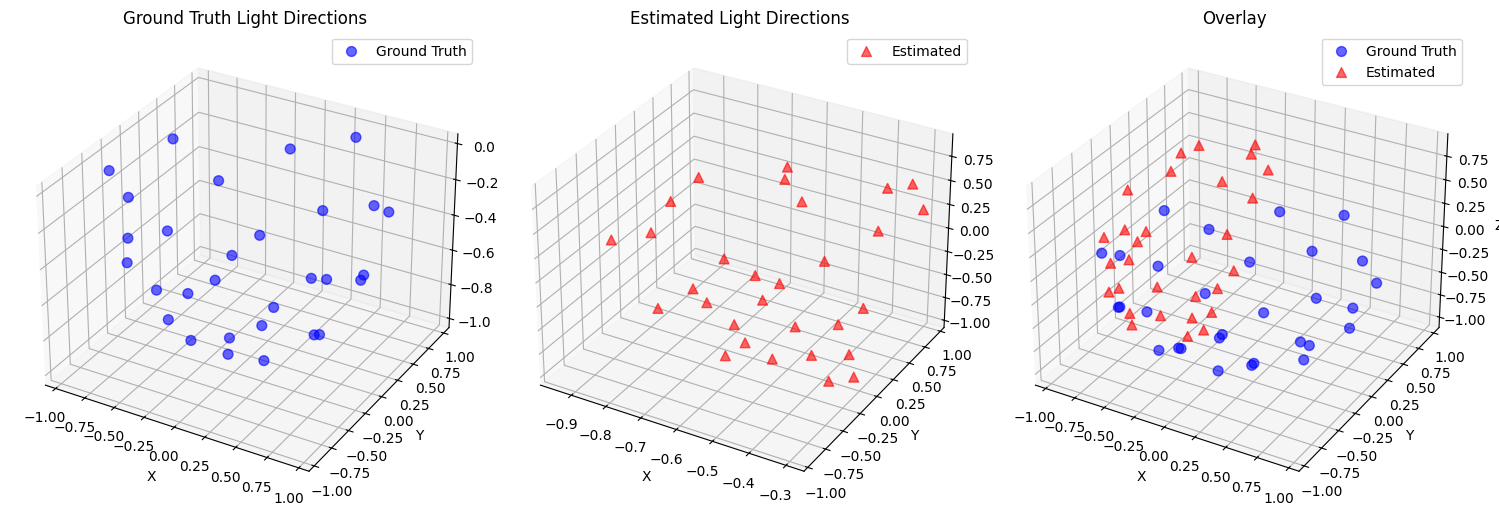


Note: Light direction comparison requires coordinate system alignment
for proper quantitative evaluation (GAS ambiguity).


In [ ]:
# Visualize light directions
fig = plt.figure(figsize=(15, 5))

# 3D scatter plot of light directions
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(light_dirs_gt[:, 0], light_dirs_gt[:, 1], light_dirs_gt[:, 2], 
           c='blue', marker='o', s=50, alpha=0.6, label='Ground Truth')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Ground Truth Light Directions')
ax1.legend()

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(light_dirs_est[:, 0], light_dirs_est[:, 1], light_dirs_est[:, 2], 
           c='red', marker='^', s=50, alpha=0.6, label='Estimated')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Estimated Light Directions')
ax2.legend()

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(light_dirs_gt[:, 0], light_dirs_gt[:, 1], light_dirs_gt[:, 2], 
           c='blue', marker='o', s=50, alpha=0.6, label='Ground Truth')
ax3.scatter(light_dirs_est[:, 0], light_dirs_est[:, 1], light_dirs_est[:, 2], 
           c='red', marker='^', s=50, alpha=0.6, label='Estimated')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('Overlay')
ax3.legend()

plt.tight_layout()
plt.show()